## Importing Libraries

In [120]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)


import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import math
from scipy.stats import zscore, iqr
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import learning_curve
from scipy.stats import f_oneway
from sklearn.feature_selection import mutual_info_regression
import itertools
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Solo muestra advertencias y errores


## 1. Data Loading

In [121]:
df = pd.read_csv('data/Consumo_cerveza_SP.csv')

## 2. Data Proprocessing

### 2.1 Data Exploring

In [122]:
df.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         365 non-null    object 
 1   Temperatura Media (C)        365 non-null    object 
 2   Temperatura Minima (C)       365 non-null    object 
 3   Temperatura Maxima (C)       365 non-null    object 
 4   Precipitacao (mm)            365 non-null    object 
 5   Final de Semana              365 non-null    float64
 6   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(2), object(5)
memory usage: 51.6+ KB


In [124]:
df.dtypes

Data                            object
Temperatura Media (C)           object
Temperatura Minima (C)          object
Temperatura Maxima (C)          object
Precipitacao (mm)               object
Final de Semana                float64
Consumo de cerveja (litros)    float64
dtype: object

### 2.2 Data Cleaning

In [125]:
df.columns

Index(['Data', 'Temperatura Media (C)', 'Temperatura Minima (C)',
       'Temperatura Maxima (C)', 'Precipitacao (mm)', 'Final de Semana',
       'Consumo de cerveja (litros)'],
      dtype='object')

In [126]:
df.columns = ['datetime', 'mean_temp', 'min_temp', 'max_temp', 'precipitation', 'end_of_week', 'beer_consumption']

In [127]:
df.isnull().sum()

datetime            576
mean_temp           576
min_temp            576
max_temp            576
precipitation       576
end_of_week         576
beer_consumption    576
dtype: int64

In [128]:
df[df.isnull().any(axis=1)]

,datetime,mean_temp,min_temp,max_temp,precipitation,end_of_week,beer_consumption
365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
df.dropna(inplace=True)

In [130]:
df.duplicated().sum()

np.int64(0)

In [131]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [132]:
df['min_temp'] = df['min_temp'].apply(lambda x: x.replace(',', '.')).astype(float)
df['mean_temp'] = df['mean_temp'].apply(lambda x: x.replace(',', '.')).astype(float)
df['max_temp'] = df['max_temp'].apply(lambda x: x.replace(',', '.')).astype(float)
df['precipitation'] = df['precipitation'].apply(lambda x: x.replace(',', '.')).astype(float)

In [133]:
df['end_of_week'] = df['end_of_week'].apply(lambda x: 1 if x else 0)

### 2.3 Data Visualization

In [134]:
float_cols = df.select_dtypes(include=['float64']).columns

#### Histogram Plot 

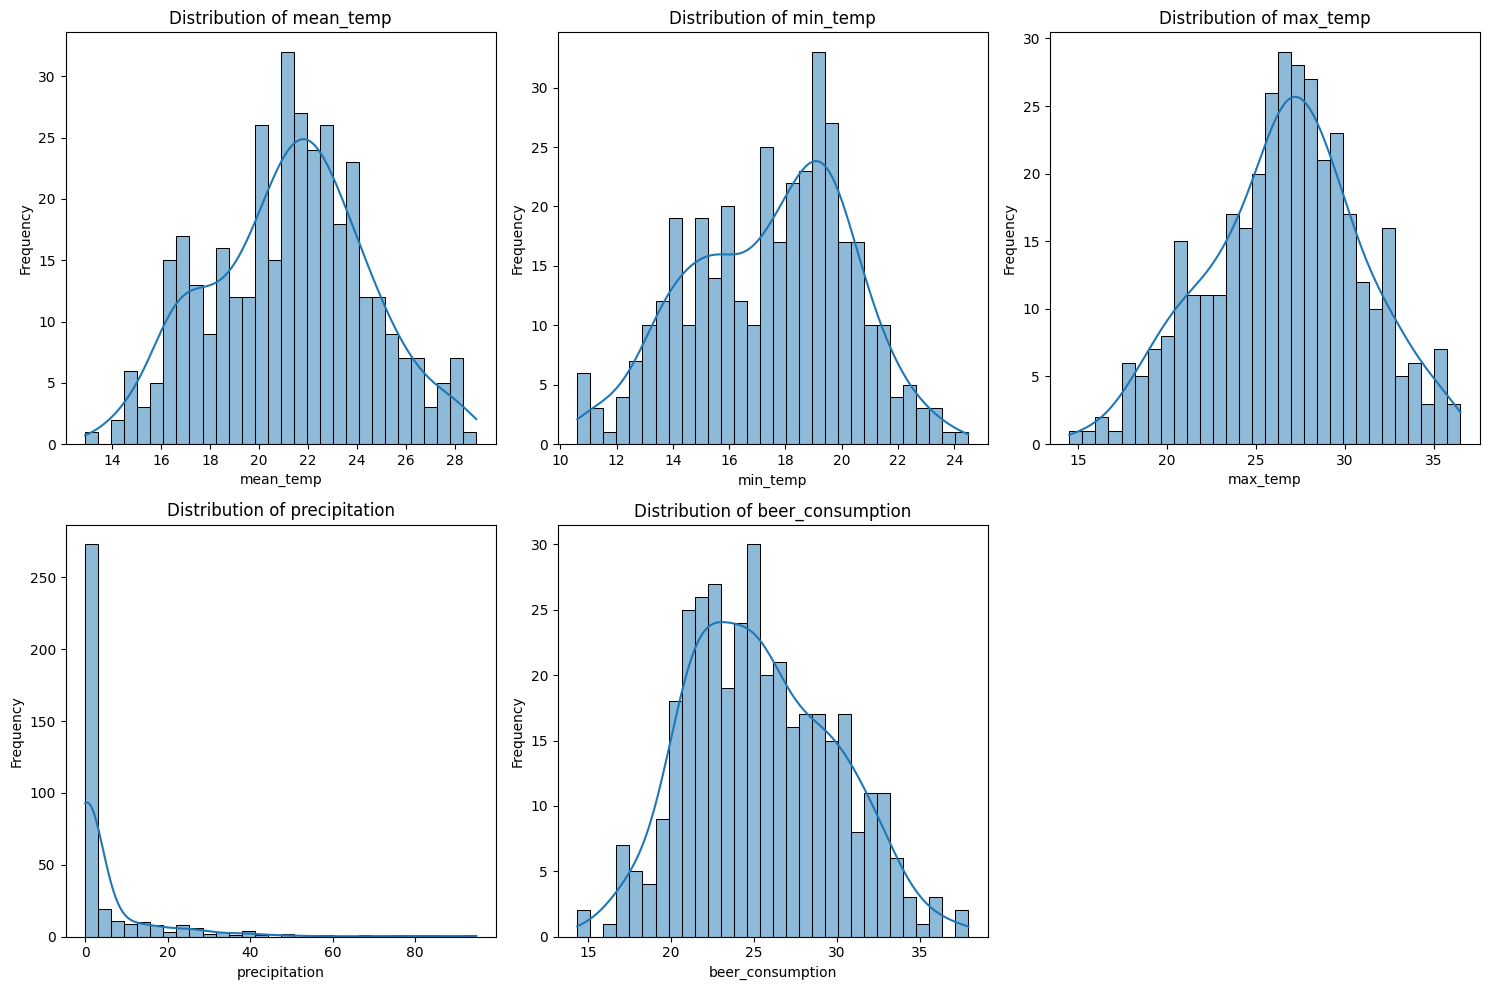

In [135]:
def plot_histogram(df, float_cols, n_cols=3, figsize=(15, 10), bins=30):
    n_rows = math.ceil(len(float_cols) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, col in enumerate(float_cols):
        sns.histplot(df[col], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_histogram(df,float_cols)

#### Hexbin plot 

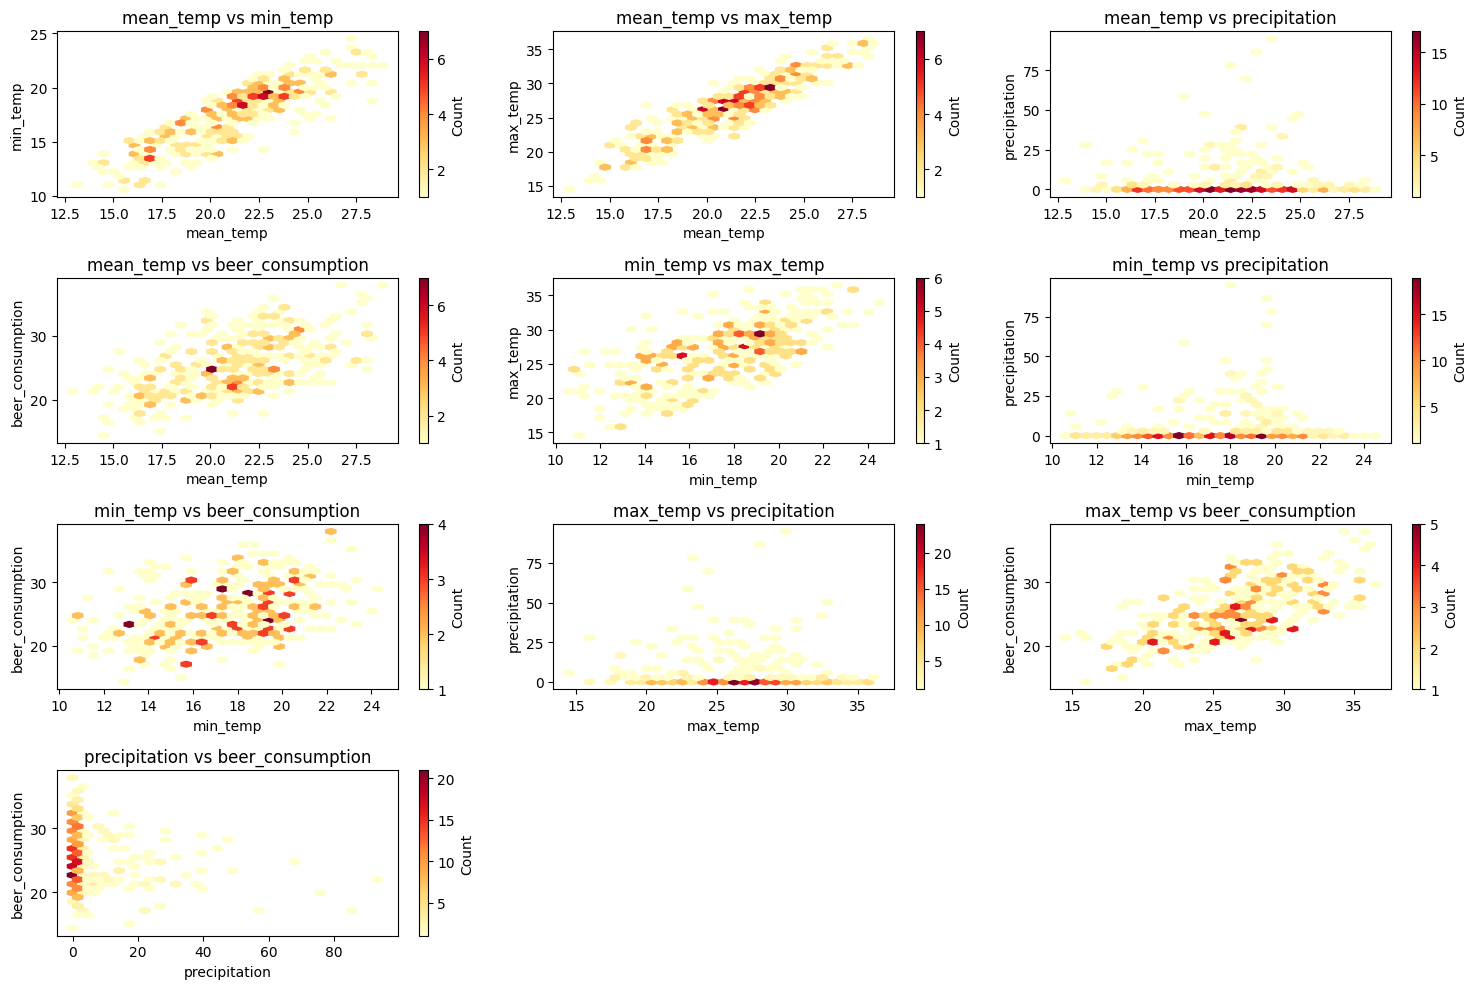

In [136]:
def plot_hexbin_matrix(df, float_cols, n_cols=3, figsize=(15, 10), gridsize=30, cmap="YlOrRd"):
    pairs = list(itertools.combinations(float_cols, 2))
    n_rows = math.ceil(len(pairs) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (col_x, col_y) in enumerate(pairs):
        hb = axes[i].hexbin(df[col_x], df[col_y], gridsize=gridsize, cmap=cmap, mincnt=1)
        axes[i].set_title(f'{col_x} vs {col_y}')
        axes[i].set_xlabel(col_x)
        axes[i].set_ylabel(col_y)
        cb = fig.colorbar(hb, ax=axes[i])
        cb.set_label('Count')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_hexbin_matrix(df, float_cols)

#### Pairplot


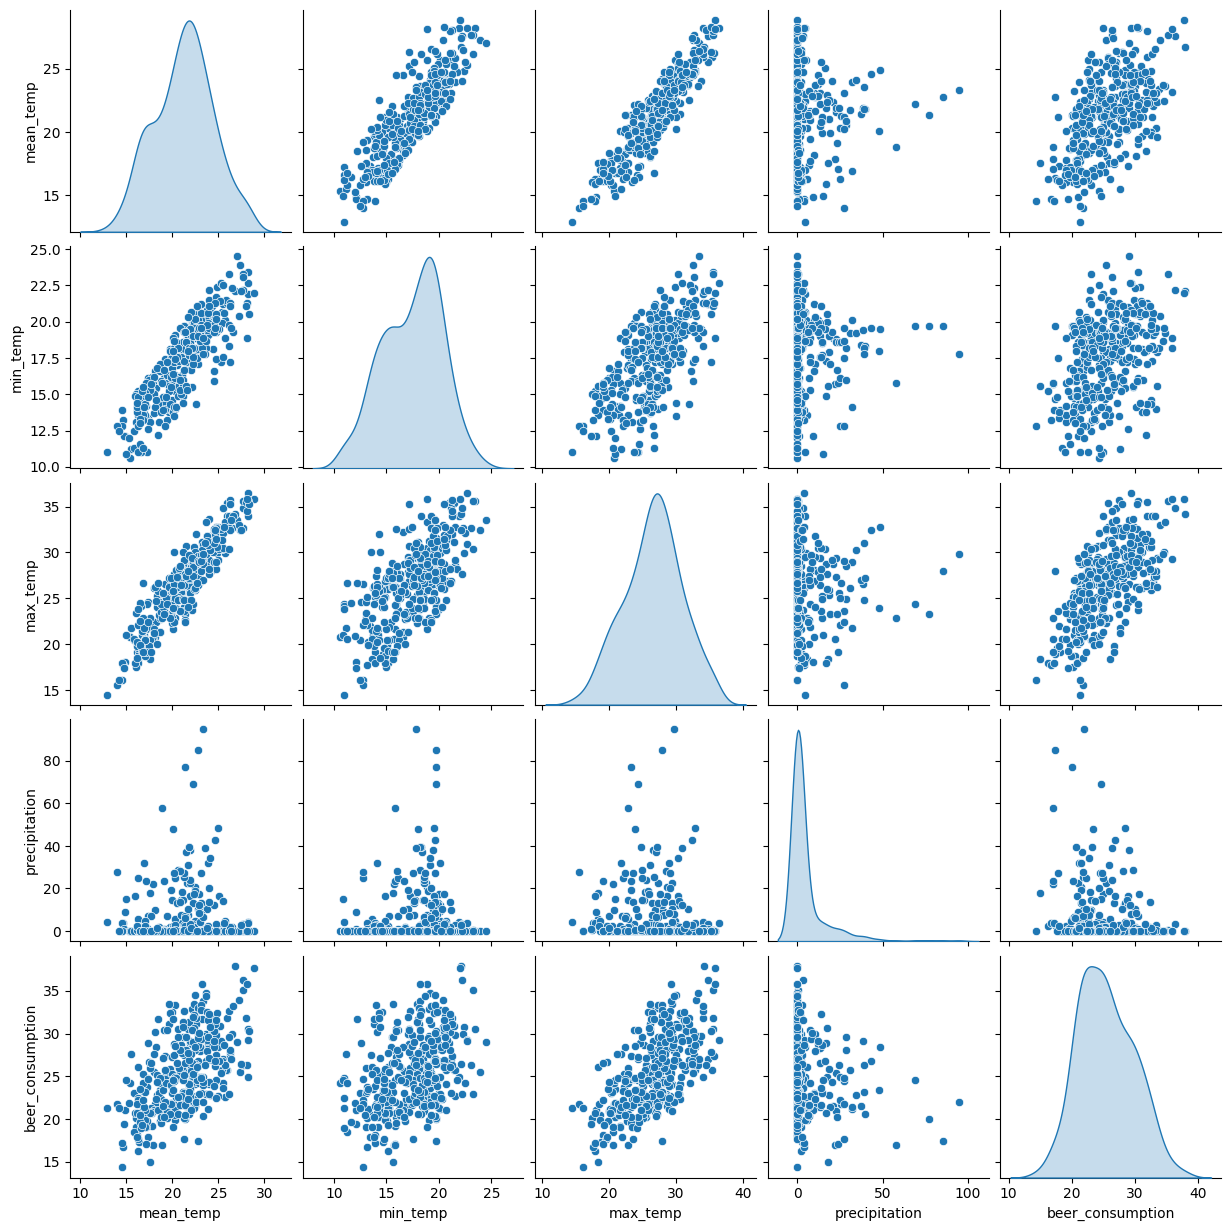

In [137]:
sns.pairplot(df[float_cols], diag_kind="kde", palette="Set2")
plt.show()

### 2.4 Missing Values Imputation

### 2.5 Outlier Handling

In [138]:
def iqr_outliers(df, columns, iqr_factor=1.5, remove=False, return_index = False):
    outliers_info = {}
    outliers_indexs = set()

    for column in columns:
        Q1 = np.percentile(df[column].dropna(), 25)
        Q3 = np.percentile(df[column].dropna(), 75)
        IQR = iqr(df[column].dropna())

        lim_inf = Q1 - iqr_factor * IQR
        lim_sup = Q3 + iqr_factor * IQR
        outliers = df[(df[column] < lim_inf) | (df[column] > lim_sup)]

        if not outliers.empty:
          outliers_info[column] = len(outliers)
          outliers_indexs.update(outliers.index)

    df_results = pd.DataFrame(outliers_info, index=['outliers']).T
    
    if remove:
        df.drop(index=outliers_indexs, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'\n{len(outliers_indexs)} were removed.')
    
    print(f'{len(outliers_indexs)} outliers')
    display(df_results)
    
    if return_index:
        return outliers_indexs

def plot_boxplots(df, columns, n_cols=3, figsize=(5, 4)):
    n_rows = math.ceil(len(columns) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        df.boxplot(column=column, ax=axes[i])
        axes[i].set_title(column)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def z_score_outliers(df, cols, threshold=3, remove=False, return_index=False):
    outliers_info = {}
    outliers_indexs = set()

    for col in cols:
        z_scores = zscore(df[col].dropna())

        outliers = df[col][(z_scores > threshold) | (z_scores < -threshold)]

        if not outliers.empty:
            outliers_info[col] = len(outliers)
            outliers_indexs.update(outliers.index)
 
    df_results = pd.DataFrame(outliers_info, index=['outliers']).T

    if remove:
        df.drop(index=outliers_indexs, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'\n{len(outliers_indexs)} were removed.')
    
    print(f'{len(outliers_indexs)} outliers')
    display(df_results)
    
    if return_index:
        return outliers_indexs

def isolation_forest_outliers(df, columns, contamination=0.05, remove=False, return_index=False):
    
    iso_for = IsolationForest(contamination=contamination)
    df_copy = df.copy()
    df_copy['outlier_score'] = iso_for.fit_predict(df_copy[columns])
    
    outliers = df_copy[df_copy['outlier_score'] == -1]
    outliers_index = outliers.index.tolist()

    if remove:
        df.drop(index=outliers_index, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'{len(outliers_index)} were dropped')

    print(f'{len(outliers)} outliers')
    
    if return_index:
        return outliers_index

In [139]:
iqr_index = iqr_outliers(df, float_cols, iqr_factor=1.5,return_index=True)

65 outliers


,outliers
max_temp,1
precipitation,64


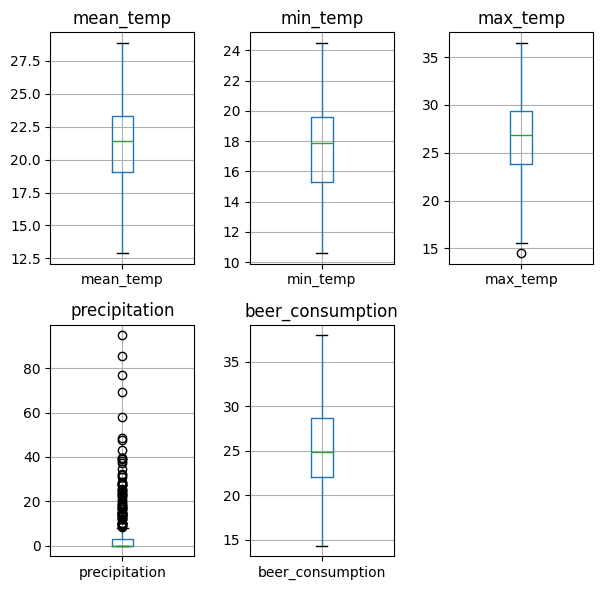

In [140]:
plot_boxplots(df, float_cols, n_cols=3, figsize=(6, 6))

In [141]:
z_index = z_score_outliers(df, float_cols, threshold=3,return_index=True)

8 outliers


,outliers
precipitation,8


In [142]:
iso_index = isolation_forest_outliers(df, float_cols, return_index=True)

19 outliers


In [143]:
intersec_index = iqr_index.intersection(z_index).intersection(iso_index)

In [144]:
intersec_index

{7, 47, 66, 67, 251, 359}

*After analyzing outliers using three different methods (IQR, Z-score, and Isolation Forest), we identified 4 data points that were flagged as outliers by all three approaches.*

In [145]:
df.drop(index=intersec_index, inplace=True)
df.reset_index(drop=True, inplace=True)

### 2.6 Feature Engineering

#### 2.6.1 Feature Selection

In [146]:
df.drop(columns=['datetime'], inplace=True)

##### Continous -> Continous

In [147]:
def corr_pearson(df, features,target , method='pearson', show_plot=False):
    
    float_cols = features.append(pd.Index([target]))
    df = df[float_cols]
    corr_info = df.corr(method=method)

    if show_plot:
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_info, annot=True, cmap='coolwarm', center=0)
        plt.show()
    else:
        corr_info = corr_info[target].sort_values(ascending=False)
        return corr_info

In [148]:
def corr_spearman(df,features,target):

    corr_info = []

    for feature in features:
        spearman_corr = df[feature].corr(df[target], method="spearman")
        corr_info.append({
            "Feature": feature,
            "Spearman Correlation": spearman_corr
        })
    
    return pd.DataFrame(corr_info).sort_values('Spearman Correlation', ascending=False)

In [149]:
def mutual_info(df, features, target):
    results = mutual_info_regression(df[features], df[target])
    results = pd.Series(results, index=features)
    return results.sort_values(ascending=False)

In [150]:
float_features = float_cols.drop('beer_consumption')

In [151]:
corr_pearson(df, float_features, 'beer_consumption', show_plot=False)

beer_consumption    1.000000
max_temp            0.648293
mean_temp           0.582588
min_temp            0.402334
precipitation      -0.155362
Name: beer_consumption, dtype: float64

In [152]:
corr_spearman(df,float_features , 'beer_consumption')

,Feature,Spearman Correlation
2,max_temp,0.646361
0,mean_temp,0.578288
1,min_temp,0.402124
3,precipitation,-0.151989


In [153]:
mutual_info(df,float_features , 'beer_consumption')

max_temp         0.314495
mean_temp        0.250168
min_temp         0.106983
precipitation    0.062315
dtype: float64

*In this situation, we can say that `precipitation` don't have an important impact in the target: `beer_consumption`, so, I will drop this variable*

In [154]:
df.drop(columns=['precipitation'], inplace=True)

##### categorical -> continous

In [155]:
def one_way_anova(df, features, target, return_results = False):
    results = []
    important_features = []
    no_important_features = []

    for feature in features:
        groups = [df[df[feature] == group][target].dropna() for group in df[feature].unique()]
        f_stat, p_value = f_oneway(*groups)

        if p_value < 0.05:
            important_features.append(feature)
            is_important = True
        else:
            no_important_features.append(feature)
            is_important = False
        
        results.append({
            "Feature": feature,
            "F-Statistic": f_stat,
            "P-Value": p_value,
            "Is Important": is_important
        })

    result_df = pd.DataFrame(results).sort_values('P-Value')

    if return_results:
        print(",".join(important_features))
        return important_features, no_important_features
    else:
        return result_df

In [156]:
categorical_features = df.select_dtypes(include=['int']).columns

In [157]:
one_way_anova(df, categorical_features, 'beer_consumption', return_results=False)

,Feature,F-Statistic,P-Value,Is Important
0,end_of_week,128.363326,1.256427e-25,True


#### 2.6.2 Feature Transformation

In [158]:
df

,mean_temp,min_temp,max_temp,end_of_week,beer_consumption
0,27.30,23.9,32.5,0,25.461
1,27.02,24.5,33.5,0,28.972
2,24.82,22.4,29.9,1,30.814
3,23.98,21.5,28.6,1,29.799
4,23.82,21.0,28.3,0,28.900
...,...,...,...,...,...
354,24.00,21.1,28.2,1,32.307
355,22.64,21.1,26.7,0,26.095
356,21.68,20.3,24.1,0,22.309
357,21.38,19.3,22.4,0,20.467


### 2.7 Feature Encoding

### 2.8 Feature Scaling

## 3. Machine Learning Models

In [159]:
regression_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R²'])
y_pred_dict = {}

def save_metrics(model, y_test, y_pred):
    global regression_metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    y_pred_dict[model] = y_pred
    
    new_row = {
        'Model': model,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }
    
    new_row_df = pd.DataFrame([new_row]).dropna(axis=1, how='all')
    regression_metrics = pd.concat([regression_metrics, new_row_df], ignore_index=True)

In [160]:
x = df.drop(columns='beer_consumption')
y = df['beer_consumption']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [161]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Bagging Regressor': BaggingRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
}

In [162]:
def model_testing(models, x_train, x_test, y_train, y_test):
    for model in models:
        models[model].fit(x_train, y_train)
        y_pred = models[model].predict(x_test)
        save_metrics(model, y_test, y_pred)

In [163]:
model_testing(models, x_train, x_test, y_train, y_test)

C:\Users\harol\AppData\Local\Temp\ipykernel_19328\3025566654.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_metrics = pd.concat([regression_metrics, new_row_df], ignore_index=True)


## 4. Model Evaluation

In [164]:
regression_metrics

,Model,MAE,MSE,RMSE,R²,MAPE
0,Linear Regression,1.939102,5.468382,2.338457,0.755736,0.078796
1,Lasso,2.734326,11.169461,3.342074,0.501077,0.112578
2,Ridge,1.939894,5.485706,2.342158,0.754962,0.078825
3,ElasticNet,2.577289,10.100982,3.178204,0.548804,0.105950
4,Decision Tree Regressor,2.793875,11.275750,3.357938,0.496329,0.113007
5,Bagging Regressor,2.213719,7.595605,2.756012,0.660716,0.089819
6,Random Forest Regressor,2.254547,7.554075,2.748468,0.662571,0.091302
7,AdaBoost Regressor,2.247111,7.138969,2.671885,0.681113,0.093108
8,Gradient Boosting Regressor,2.273604,7.997573,2.827998,0.642760,0.092012


In [165]:
def plot_residuals(y_test, y_pred_dict):
    n_preds = len(y_pred_dict)
    n_cols = 4
    n_rows = (n_preds + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    for i, (name, y_pred) in enumerate(y_pred_dict.items()):
        residuals = y_test - y_pred
        sns.histplot(residuals, kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f"{name}")
        axes[i].set_xlabel("Residuals")
        axes[i].set_ylabel("Frequency")
        axes[i].axvline(0, color='red', linestyle='--')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

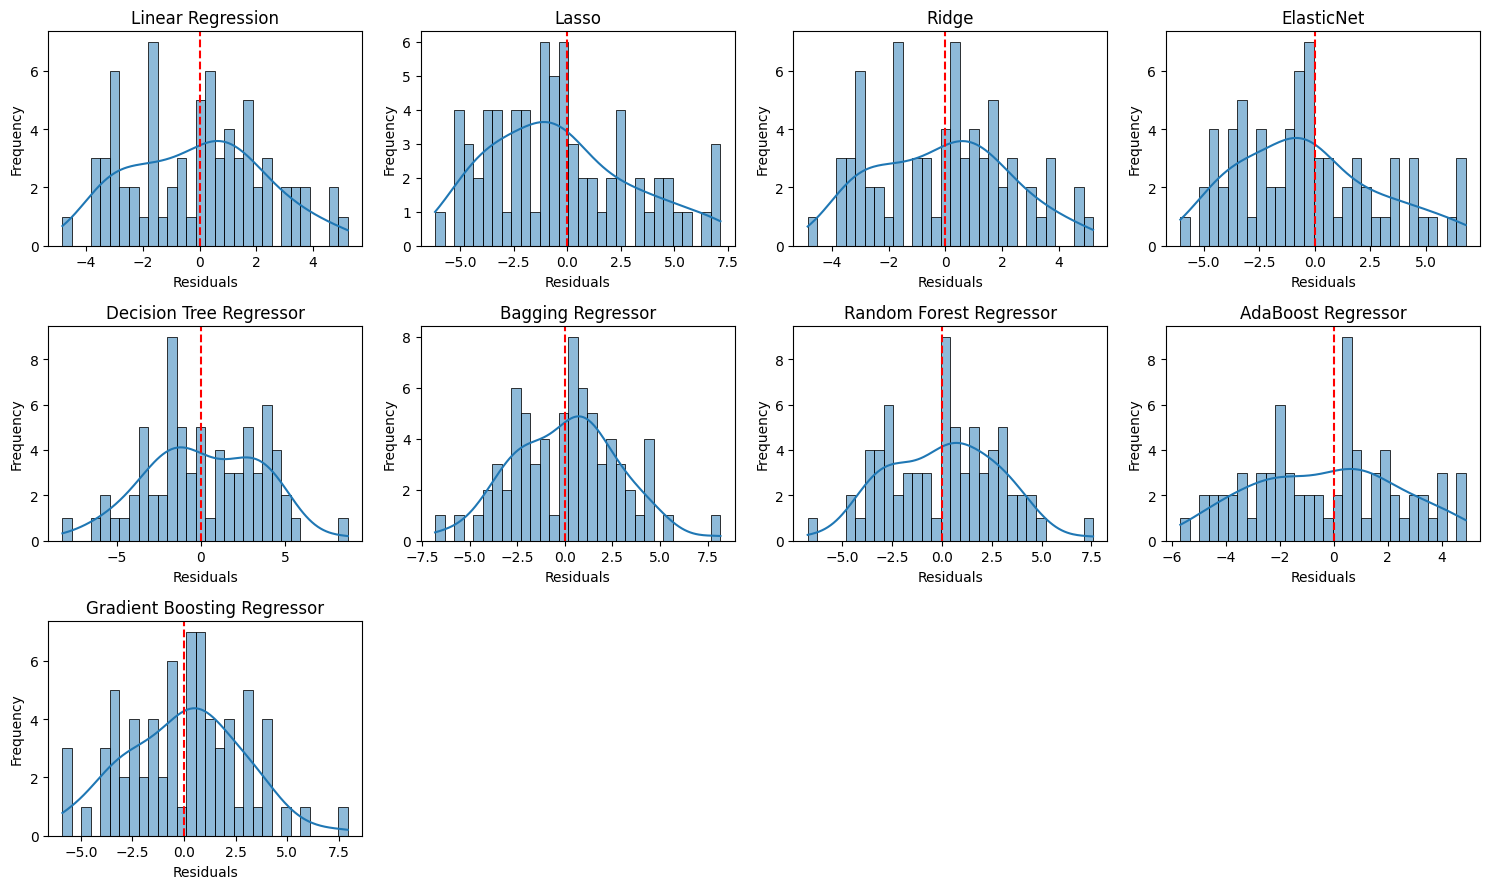

In [166]:
plot_residuals(y_test, y_pred_dict)

In [167]:
def scatter_plot(y_test, y_preds_dict):
    n_preds = len(y_preds_dict)
    n_cols = 4
    n_rows = (n_preds + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    for i, (name, y_pred) in enumerate(y_preds_dict.items()):
        plt.sca(axes[i])
        plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # diagonal
        plt.title(f'{name}')
        plt.xlabel('True Values')
        plt.ylabel('Predict Values')
        plt.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

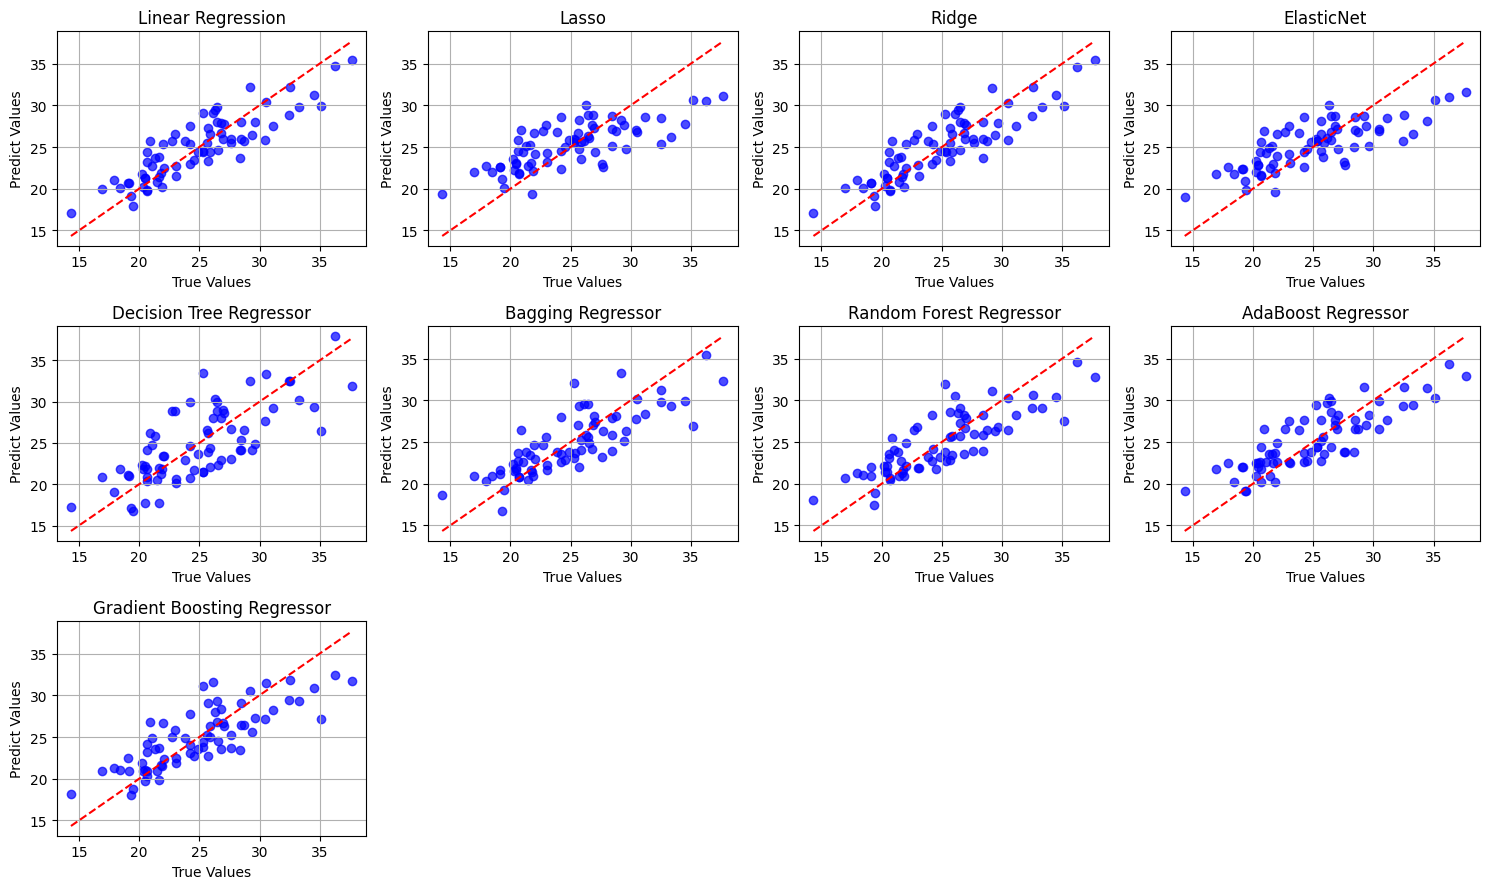

In [168]:
scatter_plot(y_test, y_pred_dict)

## 5. Model Optimization

### 5.1 Hyperparameter Tuning

In [169]:
param_dist = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
    'Lasso': {
        'alpha': np.logspace(-4, 0, 50),
        'max_iter': [1000, 2000, 3000],
        'tol': np.logspace(-5, -3, 5)
    },
    'Ridge': {
        'alpha': np.logspace(-4, 2, 100),
        'fit_intercept': [True, False],
        'tol': np.logspace(-5, -3, 100),
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'max_iter': np.arange(100, 1000, 100),
    },
    'ElasticNet': {
        'alpha': np.logspace(-4, 0, 50),
        'l1_ratio': np.linspace(0.1, 1.0, 10),
        'max_iter': [1000, 2000, 3000],
        'tol': np.logspace(-5, -3, 5)
    },
    'Decision Tree Regressor': {
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    },
    'Bagging Regressor': {
        'n_estimators': [50, 100, 150, 200],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0]
    },
    'Random Forest Regressor': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'Gradient Boosting Regressor': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': np.logspace(-3, -1, 5)  # Desde 0.001 hasta 0.1
    },
    'AdaBoost Regressor': {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': np.linspace(0.5, 1.0, 6),
        'loss': ['linear', 'square', 'exponential']
    }
}


In [170]:
y_pred_dict = {}
models_pro = {}

def regression_hyperparameter_tuning(x, y, models, param_dist,n_iter = 100, cv=5, scoring='r2'):

    for name, model in models.items():
        print(f"Tuning hyperparameter for {name}")
        random_search = RandomizedSearchCV(
            model, 
            param_dist[name],
            n_iter=n_iter, 
            cv=cv, 
            scoring=scoring,
            verbose=0,
        )
        random_search.fit(x, y)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(x_test)
        models_pro[f'{name} Pro'] = best_model
        save_metrics(f'{name} Pro', y_test, y_pred)
        print(f"Best hyperparameters for {name}: {random_search.best_params_}\n")

In [171]:
regression_hyperparameter_tuning(x, y, models, param_dist, cv=5, scoring='r2')

Tuning hyperparameter for Linear Regression
Best hyperparameters for Linear Regression: {'fit_intercept': True}

Tuning hyperparameter for Lasso
Best hyperparameters for Lasso: {'tol': np.float64(0.00031622776601683794), 'max_iter': 2000, 'alpha': np.float64(0.10481131341546852)}

Tuning hyperparameter for Ridge
Best hyperparameters for Ridge: {'tol': np.float64(0.0006579332246575682), 'solver': 'svd', 'max_iter': np.int64(100), 'fit_intercept': True, 'alpha': np.float64(1.747528400007683)}

Tuning hyperparameter for ElasticNet
Best hyperparameters for ElasticNet: {'tol': np.float64(0.0001), 'max_iter': 3000, 'l1_ratio': np.float64(1.0), 'alpha': np.float64(0.040949150623804234)}

Tuning hyperparameter for Decision Tree Regressor
Best hyperparameters for Decision Tree Regressor: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 3}

Tuning hyperparameter for Bagging Regressor
Best hyperparameters for Bagging Regressor: {'n_estimators': 150, 'max_samples

### 5.2 Model Evaluation (version Pro)

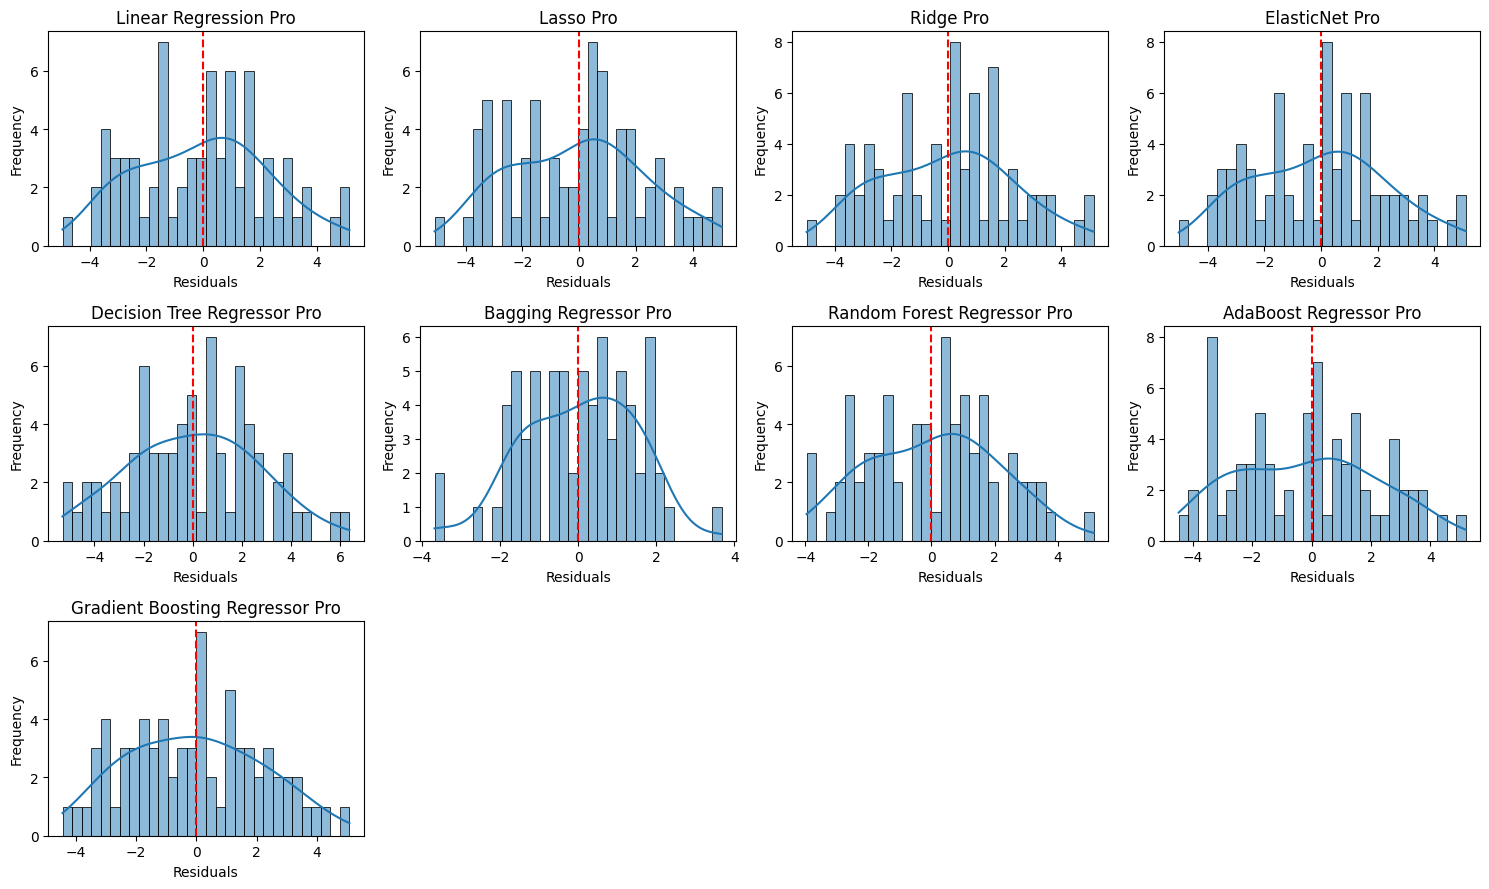

In [172]:
plot_residuals(y_test, y_pred_dict)

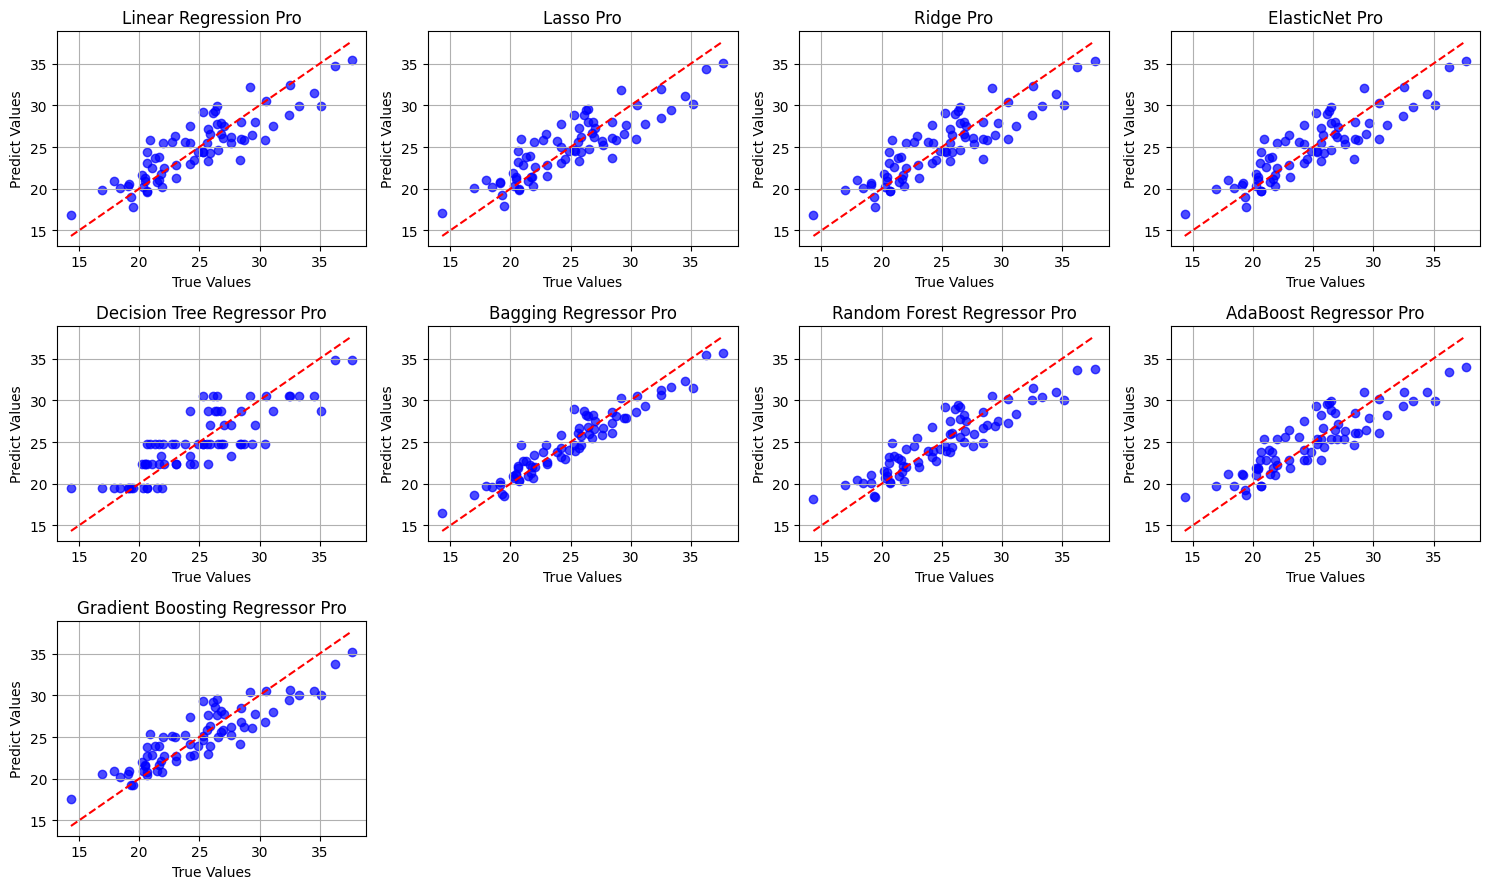

In [173]:
scatter_plot(y_test, y_pred_dict)

### 5.3 Model Validation

#### General Metrics

In [174]:
regression_metrics.sort_values('RMSE')

,Model,MAE,MSE,RMSE,R²,MAPE
14,Bagging Regressor Pro,1.185229,2.057949,1.434555,0.908074,0.048260
15,Random Forest Regressor Pro,1.713797,4.239284,2.058952,0.810638,0.069439
17,Gradient Boosting Regressor Pro,1.836784,4.921204,2.218379,0.780177,0.074511
9,Linear Regression Pro,1.910001,5.338347,2.310486,0.761544,0.077591
11,Ridge Pro,1.912889,5.357672,2.314665,0.760681,0.077709
12,ElasticNet Pro,1.919488,5.387077,2.321008,0.759367,0.077966
0,Linear Regression,1.939102,5.468382,2.338457,0.755736,0.078796
2,Ridge,1.939894,5.485706,2.342158,0.754962,0.078825
10,Lasso Pro,1.938375,5.504946,2.346262,0.754102,0.078738
16,AdaBoost Regressor Pro,1.987851,5.601532,2.366756,0.749788,0.080912


#### KFold

In [175]:
def kfold_regression_validation(x, y, models, n_splits=5, metrics=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']):

    kf = KFold(n_splits=n_splits, shuffle=True)
    results = {metric: {} for metric in metrics}
    
    for metric in metrics:
        for name, model in models.items():
            scores = cross_val_score(model, x, y, cv=kf, scoring=metric)
            results[metric][name] = {'scores': scores, 'mean_score': np.mean(scores)}
    
    num_metrics = len(metrics)
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(15, num_metrics * 3))
    
    for i, metric in enumerate(metrics):
        model_names = list(results[metric].keys())
        means = [results[metric][n]['mean_score'] for n in model_names]
        best_model = model_names[np.argmax(means)]
        
        axes[i].bar(model_names, means, color=['lightgreen' if n != best_model else 'red' for n in model_names])
        axes[i].set_ylabel(f"{metric}")
        axes[i].set_title(f"\nModel Comparison for {metric}\nBest model: {best_model}", fontsize=14)
        axes[i].tick_params(axis='x', rotation=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

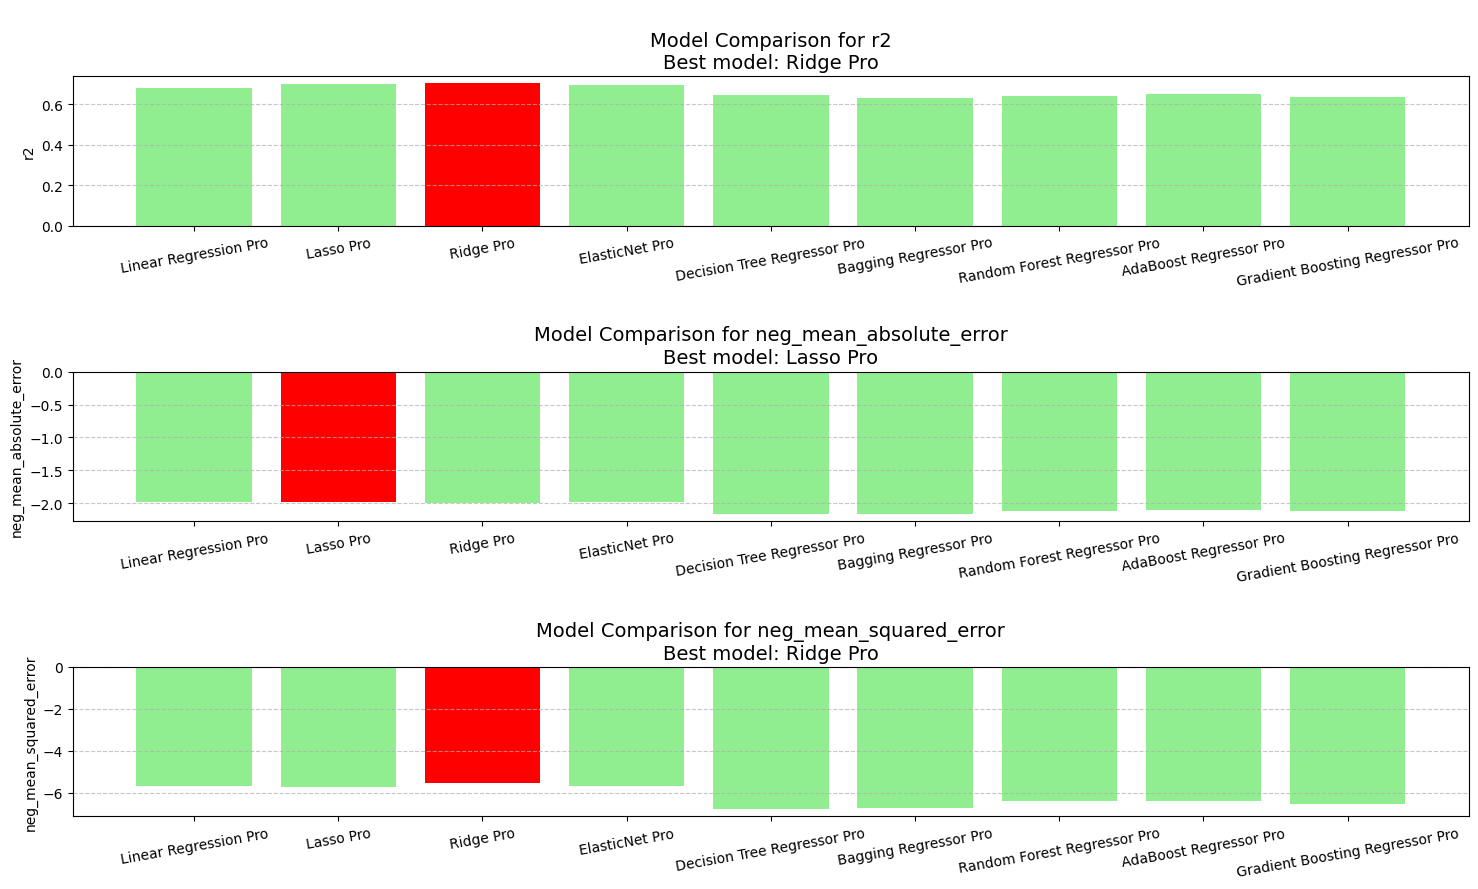

In [176]:
kfold_regression_validation(x, y, models_pro, n_splits=5)

#### Learning Curve

In [177]:
def plot_learning_curves_regression(models, x, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2', cols=3):
    num_models = len(models)
    rows = (num_models + cols - 1) // cols  # Calcula el número de filas necesarias
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()  # Asegurar que podemos indexar correctamente los subplots
    
    for idx, (name, model) in enumerate(models.items()):
        train_sizes_, train_scores, test_scores = learning_curve(model, x, y, cv=cv, train_sizes=train_sizes, scoring=scoring)
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        ax = axes[idx]
        ax.fill_between(train_sizes_, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
        ax.fill_between(train_sizes_, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax.plot(train_sizes_, train_scores_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes_, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        ax.set_title(f"Learning Curve - {name}")
        ax.set_xlabel("Training examples")
        ax.set_ylabel("Score")
        ax.legend(loc="best")
        ax.grid()
    
    # Eliminar subplots vacíos si hay más espacios de los necesarios
    for idx in range(num_models, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()


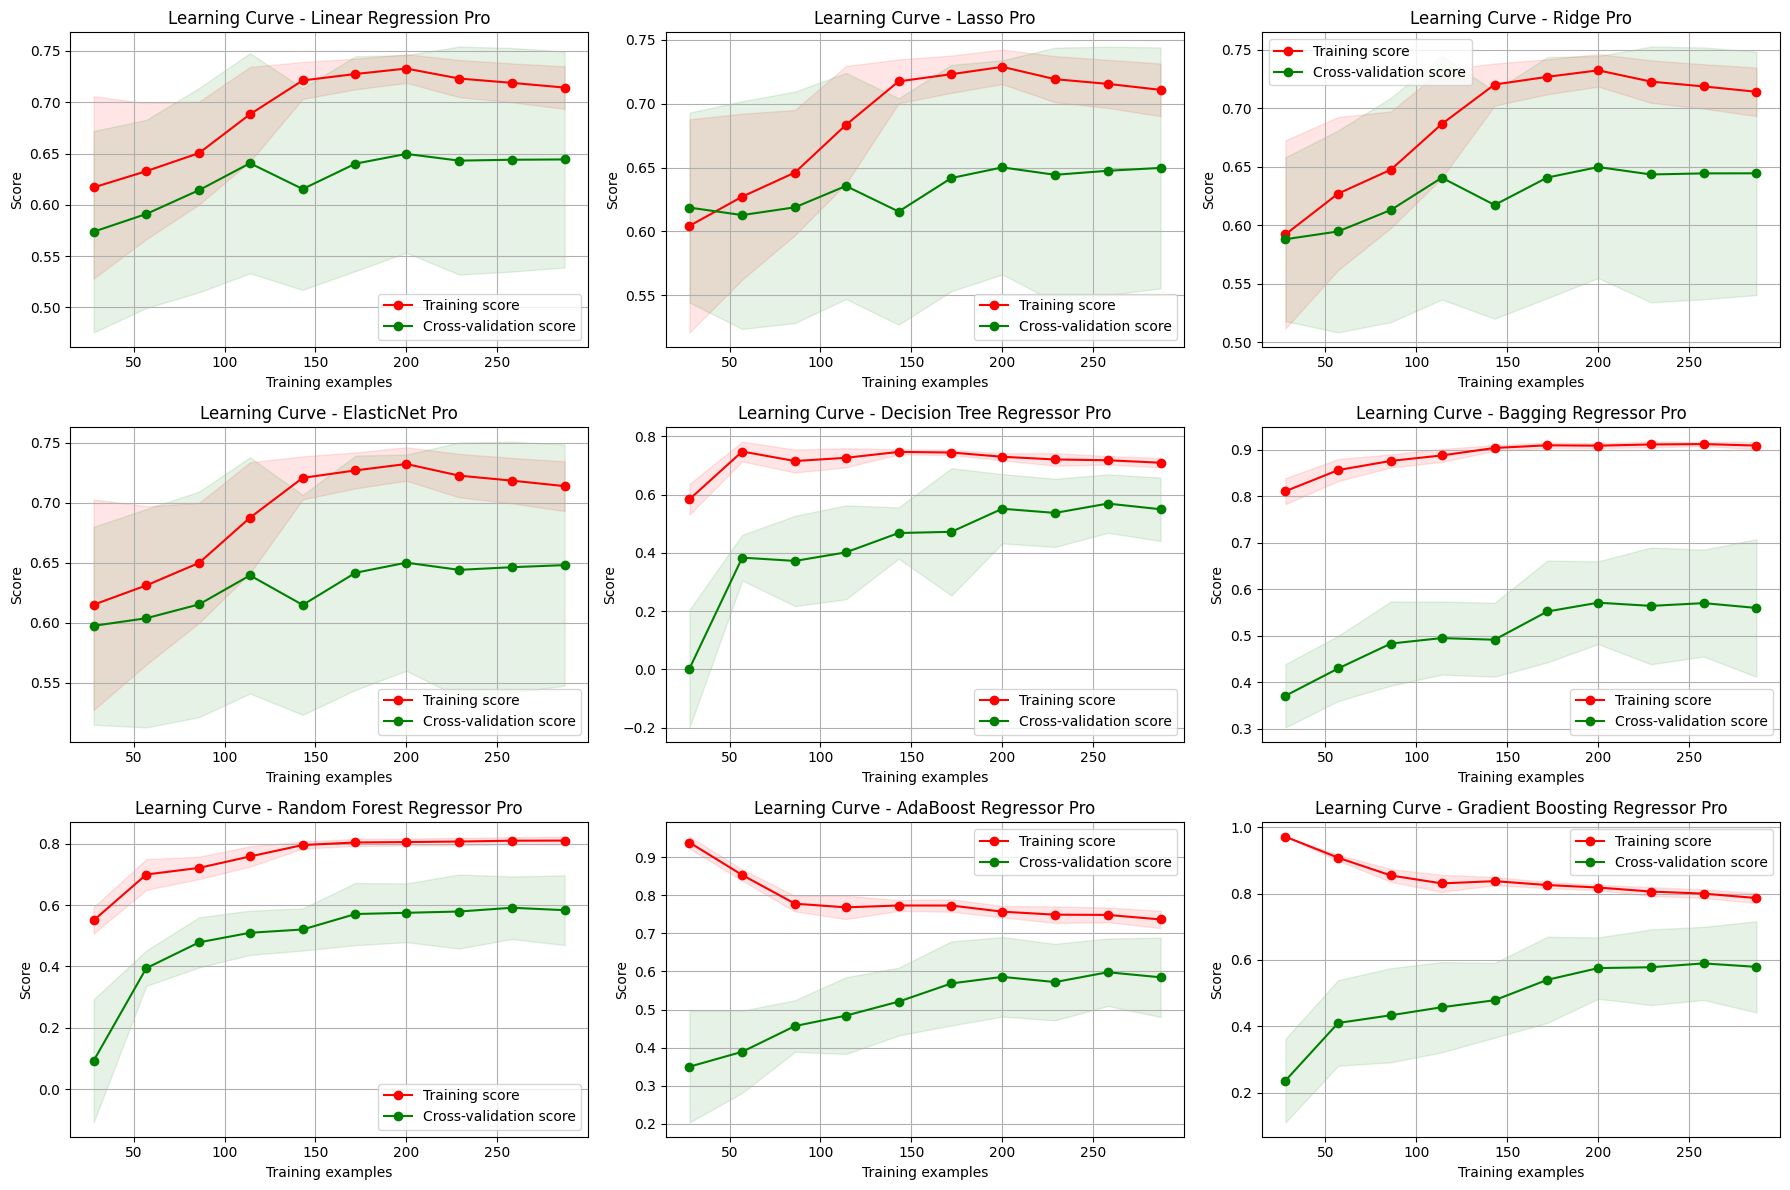

In [178]:
plot_learning_curves_regression(models_pro, x, y)

## 6. Conclusion

To choose the best model, we analyzed three key aspects:

1. **Cross-Validation (K-Fold)**: Evaluates model stability on different data partitions.
2. **Learning Curves**: Shows if the model generalizes well or suffers from overfitting or underfitting.
3. **Performance Metrics (R², MAE, MSE, RMSE, MAPE)**: Indicate the accuracy and quality of predictions.

### K-Fold Analysis

**K-Fold Cross Validation** helps measure model stability on different data subsets.

- Models like **Ridge, Lasso, and Linear Regression** stood out in some K-Fold metrics.
- They indicate stability in validation but not necessarily the best absolute performance.
- It does not detect overfitting.

### Learning Curve Analysis
The learning curve indicates if a model generalizes well.

- **Bagging Regressor Pro:** Shows a large difference between training and validation, indicating **overfitting**.
- **AdaBoost and Gradient Boosting** have more balanced curves, indicating **better generalization**.

### Performance Metrics Analysis
Metrics show the model's performance in absolute terms.

- **Bagging Regressor Pro** has the best **R² (0.908074)** and the lowest absolute errors.
- **Gradient Boosting and AdaBoost** have slightly higher errors but are more stable in validation.
- Metrics alone do not reflect overfitting issues.

### Final Conclusion

If we consider only the metrics, **Bagging Regressor Pro** seems the best option. However, its learning curve shows **overfitting**, indicating it does not generalize well.

- **Best realistic option:** **Gradient Boosting Pro or AdaBoost Pro**.
- **Gradient Boosting Pro** is a powerful option with tuned hyperparameters.
- **AdaBoost Pro** is more stable and less prone to overfitting.
